In [160]:
# выглядит красиво
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from scipy.sparse import hstack
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import ExtraTreesClassifier

In [183]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
# буду исследовать.
# я не делил на test и train, довольствуясь кроссвалидацией. на момент 20 апреля я считаю, что так делать можно.

In [ ]:
# соединил всё в кучу, чтобы сразу все данные привести в нули и единицы

In [3]:
all_data = pd.concat([data, test])

In [4]:
all_data = all_data.reset_index()
all_data.drop('index', axis=1, inplace=True)
all_data.drop('id', axis=1, inplace=True)
all_data.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [5]:
y = data.target

In [6]:
y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [174]:
4342 / (len(data))
# если данные случайно брались для теста, тогда надо получить accuracy выше этого числа, иначе классификатор - бесполезен.
# но мне кажется, что в тесте много единичек, судя по score на kaggle. Он сильно вырос по сравнению с кроссвалидацией.

0.5703402075397347

In [20]:
list(set(all_data[all_data.keyword.notna()].keyword))[:6]
# надо убрать много окончаний при помощи Stemming.

['engulfed', 'evacuation', 'sandstorm', 'avalanche', 'rescuers', 'razed']

In [21]:
all_data[all_data.keyword.notna()].keyword.value_counts()
# нет совсем малочисленных значений

body%20bags              50
burning%20buildings      50
fatal                    50
rubble                   50
suicide%20bomb           50
                         ..
forest%20fire            24
threat                   16
inundation               14
radiation%20emergency    14
epicentre                13
Name: keyword, Length: 221, dtype: int64

In [29]:
all_data[all_data.location.notna()].location.value_counts()

USA                               141
New York                          109
United States                      65
London                             58
Canada                             42
                                 ... 
Madrid, Comunidad de Madrid         1
ÌÏT: 36.142163,-95.979189           1
Southeast Michigan (HOTH)           1
Leeds, England, United Kingdom      1
KADUNA, NIGERIA                     1
Name: location, Length: 4521, dtype: int64

In [ ]:
# большинство значений придётся удалить (более 90%), потому что они бесполезны в таком виде из-за уникальности.

In [31]:
sum(all_data[all_data.location.notna()].location.value_counts() > 2)

362

In [11]:
stemmer= PorterStemmer()

In [12]:
def del_stop_words_and_punct(string):
    new_string = []
    for i in string.split():
        if i not in ENGLISH_STOP_WORDS and 'http' not in i:
            new_string.append(i)
    new_string = ' '.join(new_string)
    new_string = re.sub(r'\d+', '', new_string)
    new_string = re.sub(r'[^\w\s]','', new_string)
    return new_string

In [190]:
data_edit = all_data.copy()

In [191]:
data_edit['text'] = data_edit['text'].apply(lambda x: stemmer.stem(x))

In [192]:
data_edit['text'] = data_edit['text'].apply(lambda x: del_stop_words_and_punct(x))

In [193]:
data_edit.drop('target', axis=1, inplace=True)

In [194]:
data_edit.head()

,keyword,location,text
0,NaN,NaN,deeds reason earthquake allah forgive al
1,NaN,NaN,forest near la ronge sask canada
2,NaN,NaN,residents asked shelter place notified officer...
3,NaN,NaN,people receive wildfires evacuation orders ca...
4,NaN,NaN,just got sent photo ruby alaska smoke wildfire...


In [16]:
words_label = []
for i in data_edit[data_edit.target.notna()].text:
    words_label.extend(i.split())
words_label = set(words_label)

In [17]:
len(words_label)

17391

In [18]:
words_wolabel = []
for i in data_edit[data_edit.target.isna()].text:
    words_wolabel.extend(i.split())
words_wolabel = set(words_wolabel)

In [19]:
len(words_wolabel)

10256

In [20]:
unused_words = words_wolabel - words_label
len(unused_words)

4520

In [41]:
# потеряем 4520 слов, потому что они не участвуют в обучении модели. Слова эти довольно редкие, либо бессмысленные. Довольно много((

In [21]:
more_than_one = data_edit['location'].value_counts() > 1

In [22]:
data_edit.loc[:, ['keyword', 'location']] = data_edit.loc[:, ['keyword', 'location']].fillna('Unknown')

In [23]:
data_edit.loc[:, 'location'] = data_edit.loc[:, 'location'].apply(lambda x: 'Unknown' if more_than_one[x] == False else x)

In [24]:
data_edit.location.value_counts()

Unknown                           7431
USA                                141
New York                           109
United States                       65
London                              58
                                  ... 
Jakarta, Indonesia                   2
London                               2
Bukittinggi  ?? Sumatera Barat       2
The Jewfnited State                  2
Dorset, UK                           2
Name: location, Length: 730, dtype: int64

In [25]:
def delete_unused_words(x):
    new_x = []
    for i in x.split():
        if i not in unused_words:
            new_x.append(i)
    return ' '.join(new_x)

In [26]:
for i in data_edit[data_edit['target'].isna()].index:
    data_edit.loc[i, 'text'] = delete_unused_words(data_edit.loc[i, 'text'])

In [163]:
data_edit[data_edit.text.isna()]
#нет na после этой операции, к счастью.

,keyword,location,text,target


In [ ]:
# убрать аналогично location и keyword

In [27]:
delete_location = set(data_edit[data_edit['target'].isna()]['location']) - set(data_edit[data_edit['target'].notna()]['location'])

In [28]:
for i in data_edit[data_edit['target'].isna()].index:
    if data_edit.loc[i, 'location'] in delete_location:
        data_edit.loc[i, 'location'] = 'Unknown'

In [29]:
set(data_edit[data_edit['target'].isna()]['location']) - set(data_edit[data_edit['target'].notna()]['location'])

set()

In [30]:
set(data_edit[data_edit['target'].notna()]['keyword']) - set(data_edit[data_edit['target'].isna()]['keyword'])
# пусто

set()

In [ ]:
# теперь идём к моделям через pipeline

In [41]:
code_col = ['keyword', 'location']

In [42]:
full_pipeline = ColumnTransformer([
    ('text', CountVectorizer(), 'text'),
    ('cat', OneHotEncoder(handle_unknown="ignore"), code_col)
])

In [43]:
full_data_prep = full_pipeline.fit_transform(data_edit)

In [44]:
full_train_prep = full_data_prep[:len(y), :]
answer_prep = full_data_prep[len(y):, :]

In [70]:
sgd_clf = SGDClassifier()
rnf_clf = RandomForestClassifier()
ext_clf = ExtraTreesClassifier()
svc_clf = SVC()
mlp_clf = MLPClassifier()
logic_clf = LogisticRegression()
estimators = [sgd_clf, rnf_clf, ext_clf, svc_clf, mlp_clf, logic_clf]

In [72]:
for est in estimators:
    print(est.__class__.__name__, np.mean(cross_val_score(est, full_train_prep, y, scoring='accuracy', cv=5, verbose=0)))
# самое простое оказывается достаточно эффективным.

SGDClassifier 0.6356267412595136
RandomForestClassifier 0.6218360953336617
ExtraTreesClassifier 0.6147426710716021
SVC 0.6637433207679359
MLPClassifier 0.6156631173517237
LogisticRegression 0.6561215976145014


In [ ]:
# далее я подкручиваю параметры... Некоторые клетки удалял.

In [75]:
params_svc = {'kernel': ['poly', 'rbf', 'sigmoid'], 'C':[1, 5, 15, 50], 'degree':[3, 4, 5, 6]}
grid_svc = GridSearchCV(svc_clf, params_svc, scoring='accuracy', cv=3, verbose=2)

In [82]:
# grid_svc.fit(full_train_prep, y)

In [77]:
grid_svc.best_params_

{'C': 5, 'degree': 3, 'kernel': 'rbf'}

In [81]:
svc_clf = SVC(**grid_svc.best_params_, probability=True)
np.mean(cross_val_score(svc_clf, full_train_prep, y, scoring='accuracy', cv=5, verbose=0))

0.6621642049244049

In [87]:
ada_clf = AdaBoostClassifier(svc_clf)
# пытаюсь бустинг прикрутить к svc

In [88]:
np.mean(cross_val_score(ada_clf, full_train_prep, y, scoring='accuracy', cv=5, verbose=0))
# за это время (часа 3) я успел уже нарисовать 2 рисунка с ромашками. А результат не очень. Возможно я какую-то ерунду сделал.

0.5744100748660703

In [99]:
params_log = {'penalty':['l2'],
             'C':[0.02, 0.05, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
             'solver':['saga']}

In [100]:
grid_log = GridSearchCV(logic_clf, params_log, scoring='accuracy', cv=3, verbose=2)

In [105]:
grid_log.fit(full_train_prep, y)

In [106]:
grid_log.best_score_
# его надо постараться улучшить на кроссвалидации. Что впоследствии я не смог сделать и оставил этот классификатор.

0.6999923071817893

In [ ]:
# ниже моя попытка сделать stacking моделей

In [171]:
rnf_clf = RandomForestClassifier(bootstrap=True, min_samples_leaf=2, n_estimators=128)
ext_clf = ExtraTreesClassifier(bootstrap=True, min_samples_leaf=2, n_estimators=128)
svc_clf = SVC(**grid_svc.best_params_, probability=True)
logic_clf = LogisticRegression(solver='saga', penalty='l2', C=0.2, max_iter=500)
estimators = [rnf_clf, ext_clf, svc_clf, logic_clf]

In [130]:
list_y_pred = []
for est in estimators:
    est.fit(full_train_prep, y)
    y_pred = est.predict_proba(full_train_prep)
    list_y_pred.append(y_pred)

In [131]:
list_y_pred = np.asarray(list_y_pred, dtype=np.float32)

In [150]:
list_y_pred = list_y_pred.reshape(len(y), 8)

In [157]:
stack_svc = SVC()

In [158]:
stack_svc.fit(list_y_pred, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [159]:
np.mean(cross_val_score(stack_svc, list_y_pred, y, scoring='accuracy', cv=5, verbose=0))

0.5661352041366589

In [ ]:
# я попробовал разные классификаторы и чот значение не переходит 0.6 даже. мой терминатор из разных моделей не удался :(

In [177]:
vote_clf = VotingClassifier([('rnf', rnf_clf), ('ext', ext_clf), ('svc', svc_clf), ('logic', logic_clf)], voting='soft')

In [178]:
np.mean(cross_val_score(vote_clf, full_train_prep, y, scoring='accuracy', cv=5, verbose=0))

0.645743798764973

In [179]:
logic_clf = LogisticRegression(solver='saga', penalty='l2', C=0.2, max_iter=500)
logic_clf.fit(full_train_prep, y)
np.mean(cross_val_score(logic_clf, full_train_prep, y, scoring='accuracy', cv=5, verbose=0))

0.676091778882367

In [ ]:
# попытка хорошая, но не превзошёл логистическую регрессию. Так к чему я это всё делал?

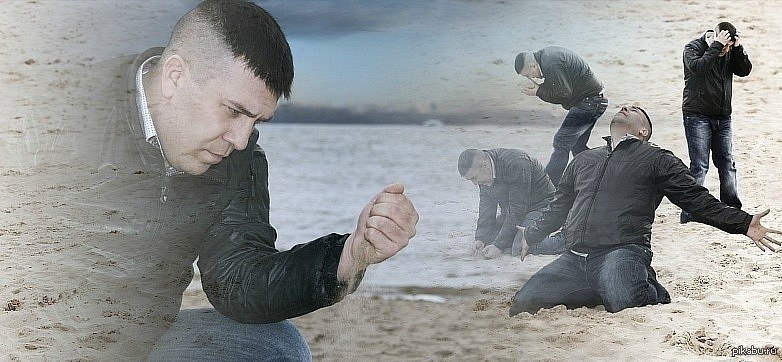

In [180]:
y_prep = logic_clf.predict(answer_prep)

In [185]:
submission['target'] = y_prep

In [187]:
submission.to_csv('end_answer.csv',index=False)

In [ ]:
#  0.80368 результат, а прошлый 0.78732. Мне кажется, что можно каким-то образом поднять выше результат, если хорошо поработать на этапе подготовки данных.

In [ ]:
vote_clf.fit(full_train_prep, y)
y_prep = vote_clf.predict(answer_prep)
submission['target'] = y_prep
submission.to_csv('end_answer_vote.csv',index=False)

In [ ]:
# попытка не пытка, подумал я и voting_classifier пустил на submission. 0.80981. Ура: Повышение на целых 0.6%. Правда жизни: То есть кроссвалидация не является показателем успешности на тесте...

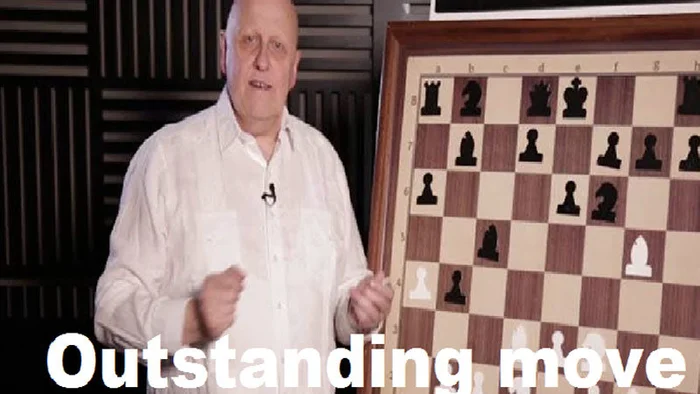